In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Data Analysis

In [61]:
# Connect SQLite.
dbconn = sqlite3.connect('../data/IowaLiquorSales.db')
cursor = dbconn.cursor()

# Pull Store database.
query = '''SELECT Sales.Date, Sales.ProductID, Product.CategoryGroup, Sales.VendorID, Product.Proof, Sales.StoreID, Sales.VolumeSold_Gallons, Sales.Sale_Dollars, Price.StateBottleRetail
              FROM ((Sales 
              INNER JOIN Product ON Sales.ProductID=Product.ProductID)
              INNER JOIN Price ON Sales.ProductID=Price.ProductID and Sales.Date=Price.Date)
              WHERE Sales.Date BETWEEN '2019-01-01' AND '2019-12-31';'''
cursor.execute(query)
result = cursor.fetchall()
cursor.close()
dbconn.close()

In [62]:
# Put the database in a data frame format.
temp = pd.DataFrame(result, columns = ['Date',
                                            'ProductID',
                                            'CategoryGroup',
                                            'VendorID',
                                            'Proof',
                                            'StoreID',
                                            'VolumeSold_Gallons',
                                            'Sale_Dollars',
                                            'StateBottleRetail'])

In [63]:
temp.head()

,Date,ProductID,CategoryGroup,VendorID,Proof,StoreID,VolumeSold_Gallons,Sale_Dollars,StateBottleRetail
0,2019-03-19,26826,whisky,85,80.0,2513,4.75,560.64,23.36
1,2019-05-15,86251,liqueur,434,30.0,5068,3.17,43.56,3.63
2,2019-05-16,89566,tequila,55,80.0,2588,0.19,19.89,19.89
3,2019-05-15,35926,vodka,297,80.0,2647,2.37,60.72,5.06
4,2019-05-14,42699,rum,370,42.0,5202,0.59,33.72,11.24


In [64]:
temp.shape[0]

2380344

In [67]:
temp['Date'].min()

'2019-01-02'

In [68]:
temp['Date'].max()

'2019-12-31'

Text(0, 0.5, 'Product Sold')

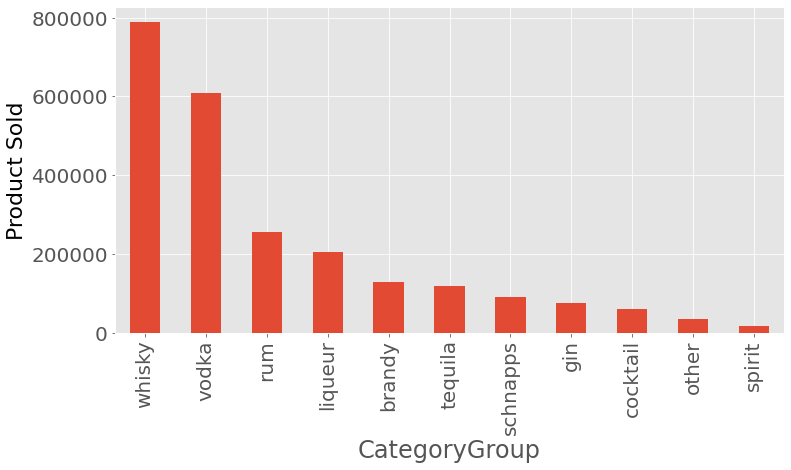

In [66]:
fig = plt.figure(figsize = (12,6))
temp.groupby('CategoryGroup').size().sort_values(ascending=False).plot.bar()

plt.ylabel('Product Sold',fontsize=22, color = 'black')